In [86]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, accuracy_score

In [87]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("../input/train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("../input/test.csv", dtype={"Age": np.float64}, )

# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [88]:
titanic_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [89]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

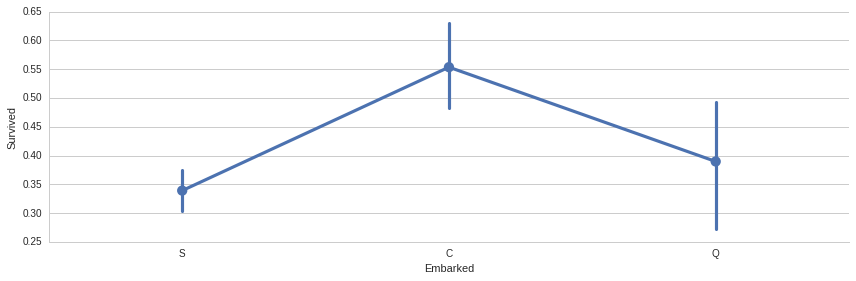

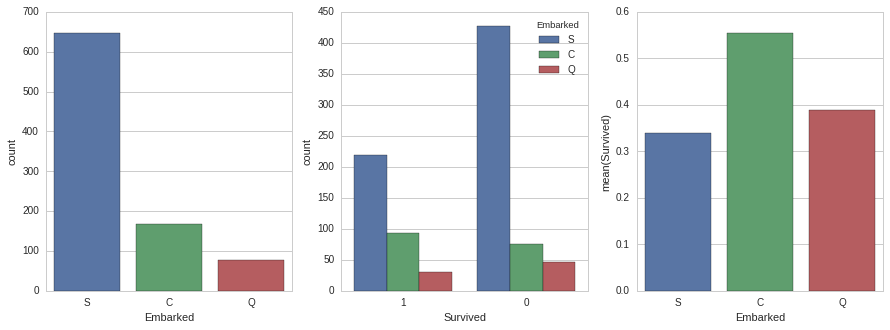

In [90]:
# Embarked

# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# plot
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# sns.factorplot('Embarked',data=titanic_df,kind='count',order=['S','C','Q'],ax=axis1)
# sns.factorplot('Survived',hue="Embarked",data=titanic_df,kind='count',order=[1,0],ax=axis2)
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

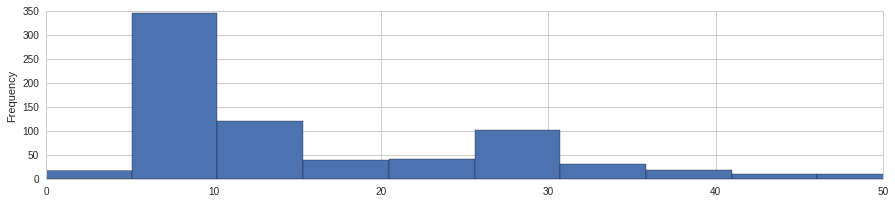

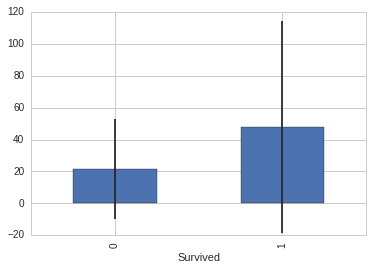

In [91]:
# Fare

# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

/home/kyle/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kyle/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


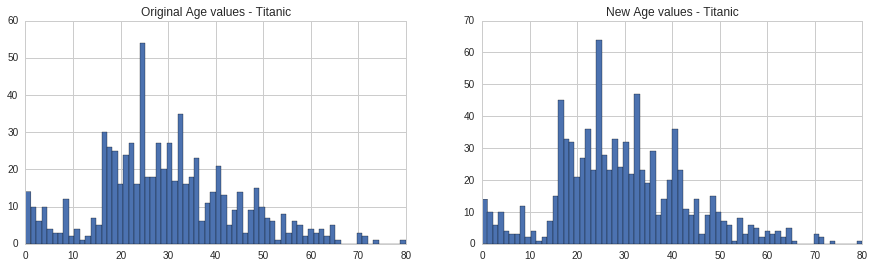

In [92]:
# Age 

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# axis3.set_title('Original Age values - Test')
# axis4.set_title('New Age values - Test')

# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# plot original Age values
# NOTE: drop all null values, and convert to int
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
# test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)
        
# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)
# test_df['Age'].hist(bins=70, ax=axis4)

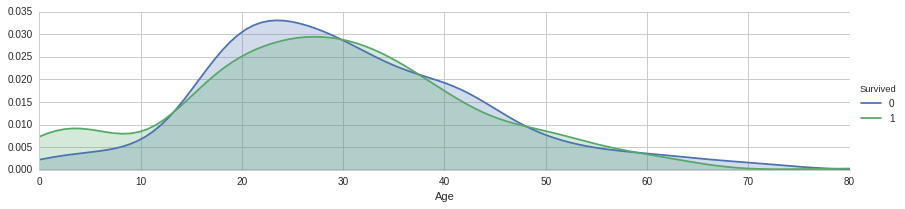

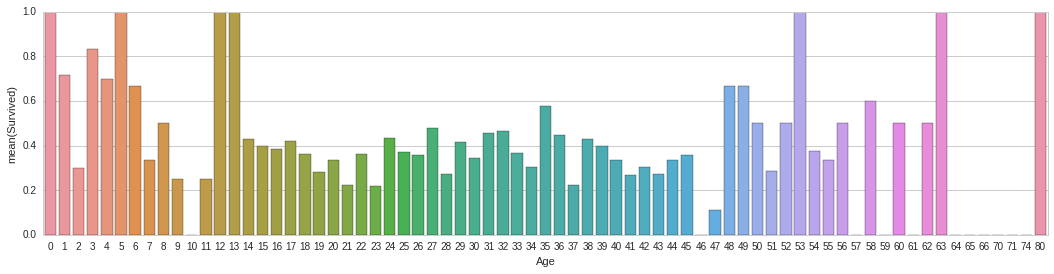

In [93]:
# .... continue with plot Age column

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [94]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

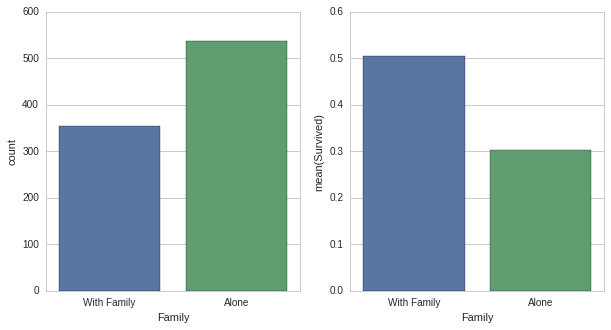

In [95]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Family', data=titanic_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = titanic_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

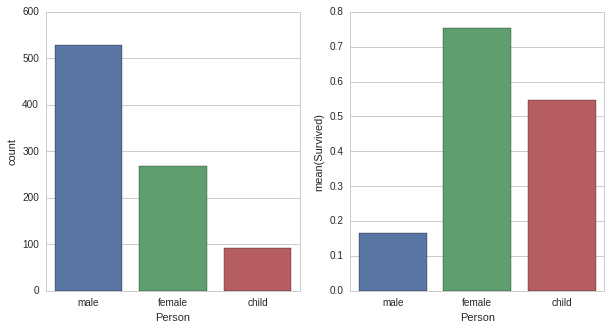

In [96]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

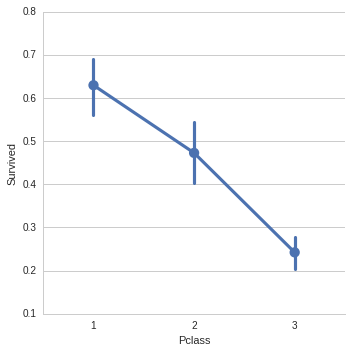

In [97]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

In [98]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [99]:
# Logistic Regression

logreg = LogisticRegression(penalty='l2')

accuracy_scorer = make_scorer(accuracy_score)

parameters = {'C':[0.03125, 0.0625,.125,.25,.5,1,2,4,8,16,32]}
grid_search_CV = GridSearchCV(logreg, parameters, cv=10, scoring=accuracy_scorer)
grid_search_CV.fit(X_train, Y_train)
print("score equals %f" % (grid_search_CV.best_score_))
print("%s" % (grid_search_CV.best_params_))
logreg = grid_search_CV.best_estimator_

Y_pred_regression = logreg.predict(X_test)

logreg_score = logreg.score(X_train, Y_train)

print(logreg_score)

score equals 0.811448
{'C': 0.25}
0.811447811448


In [100]:
# Support Vector Machines

svc = SVC(max_iter = 1000000)

parameters = {"C":[1.5e-1,2e-1,3e-1], "kernel":["linear"]}
grid_search_CV = GridSearchCV(svc, parameters, cv=40, scoring=accuracy_scorer, verbose=10)
grid_search_CV.fit(X_train, Y_train)
print("score equals %f" % (grid_search_CV.best_score_))
print("%s" % (grid_search_CV.best_params_))
svc = grid_search_CV.best_estimator_

# svc.fit(X_train, Y_train)

Y_pred_svc = svc.predict(X_test)

svc_score = svc.score(X_train, Y_train)

print(svc_score)

Fitting 40 folds for each of 3 candidates, totalling 120 fits
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.695652 -   1.0s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.695652 -   1.0s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.782609 -   0.6s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.826087 -   0.9s

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    3.5s



[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.782609 -   1.1s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.826087 -   0.9s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.695652 -   0.5s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.826087 -   0.8s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.652174 -   0.8s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.869565 -   0.8s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.826087 -   1.0s
[CV] 

[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:   10.4s



[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.782609 -   1.0s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.869565 -   0.9s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.956522 -   0.9s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.869565 -   1.1s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.826087 -   0.8s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.652174 -   0.8s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.782609 -   0.8s
[CV] 

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:   15.2s
[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:   20.7s



[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.727273 -   1.0s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.772727 -   0.6s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.772727 -   0.8s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.727273 -   1.0s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.727273 -   1.0s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.714286 -   1.0s
[CV] kernel=linear, C=0.15 ...........................................
[CV] .................. kernel=linear, C=0.15, score=0.666667 -   0.8s
[CV] 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   27.0s
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:   35.0s



[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.695652 -   1.4s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.695652 -   0.9s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.782609 -   1.1s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.826087 -   1.1s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.782609 -   1.2s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.826087 -   1.0s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.826087 -   0.9s
[CV] 

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   44.5s
[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:   57.7s



[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.826087 -   0.9s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.739130 -   1.2s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.818182 -   1.2s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.727273 -   1.1s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.727273 -   1.2s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.772727 -   1.1s
[CV] kernel=linear, C=0.2 ............................................
[CV] ................... kernel=linear, C=0.2, score=0.772727 -   1.3s
[CV] 

[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  84 tasks       | elapsed:  1.5min



[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.782609 -   1.5s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.826087 -   1.4s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.826087 -   1.1s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.826087 -   1.8s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.652174 -   1.7s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.869565 -   1.7s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.826087 -   1.5s
[CV] 

[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done 112 tasks       | elapsed:  2.2min



[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.809524 -   1.6s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.761905 -   0.9s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.857143 -   1.5s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.857143 -   2.8s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.666667 -   1.9s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.857143 -   2.5s
[CV] kernel=linear, C=0.3 ............................................
[CV] ................... kernel=linear, C=0.3, score=0.761905 -   2.2s
[CV] 

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.5min finished


In [136]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100,criterion='entropy')

#random_forest.fit(X_train, Y_train)

parameters = {'max_depth':[6], 'min_samples_split':[20], 'n_estimators':[100]}
grid_search_CV = GridSearchCV(random_forest, parameters, cv=10, scoring=accuracy_scorer)
grid_search_CV.fit(X_train, Y_train)
print("score equals %f" % (grid_search_CV.best_score_))
print("%s" % (grid_search_CV.best_params_))
random_forest = grid_search_CV.best_estimator_

Y_pred_rf = random_forest.predict(X_test)

rf_score = random_forest.score(X_train, Y_train)

print(rf_score)

score equals 0.812570
{'min_samples_split': 20, 'n_estimators': 100, 'max_depth': 6}
0.852974186308


In [121]:
import math

from sklearn.cross_validation import KFold
from numpy.random import RandomState

#def weighted_distance(x,y):
#    distance = 0
#    distance += 0.028363*math.abs(y[0]-x[0])
#    distance += 2.396e-3*math.abs(y[1]-x[1])
#    distance += 0.458447*math.abs(y[2]-x[2])
#    distance += 0.175064*math.abs(y[3]-x[3])
#    distance += 0.078103*math.abs(y[4]-x[4])
#    distance += 1.062221*math.abs(y[5]-x[5])
#    distance += 2.325044*math.abs(y[6]-x[6])
#    distance += 1.539575*math.abs(y[7]-x[7])
#    distance += 0.835521*math.abs(y[8]-x[8])
##    distance = math.sqrt(distance)
#    return distance
    
parameters = {'n_neighbors':[5,6,7,8,9,10,11]}

V = np.cov(np.transpose(X_train.as_matrix()))

knn = KNeighborsClassifier(metric='mahalanobis', metric_params={'V':V}, weights='distance')

skf = KFold(n=len(Y_train), n_folds=len(Y_train))

grid_search_CV = GridSearchCV(knn, parameters, cv=skf, scoring=accuracy_scorer)
grid_search_CV.fit(X_train, Y_train)
print("best score equals %f" % (grid_search_CV.best_score_))
print("%s" % (grid_search_CV.best_params_))
knn = grid_search_CV.best_estimator_

#knn.fit(X_train, Y_train)

Y_pred_knn = knn.predict(X_test)

knn_score = knn.score(X_train, Y_train)

print(knn_score)

best score equals 0.793490
{'n_neighbors': 6}
0.967452300786


In [103]:
# Gaussian Naive Bayes

gaussian = GaussianNB()

gaussian.fit(X_train, Y_train)

Y_pred_gaussian = gaussian.predict(X_test)

gaussian_score = gaussian.score(X_train, Y_train)

print(gaussian_score)

0.759820426487


In [104]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Age,-0.034102
1,Fare,0.001841
2,C,0.493345
3,Q,0.142628
4,Family,-0.057455
5,Child,0.948405
6,Female,2.324287
7,Class_1,1.635567
8,Class_2,0.894690


In [134]:
# put ensemble together
#total_score = knn_score + rf_score + svc_score + logreg_score

Y_pred_avg = (1./3.) * Y_pred_knn + (1./3.) * Y_pred_rf + (1./3.) * Y_pred_svc
#Y_pred_avg = Y_pred_rf
#Y_pred_avg = Y_pred_svc
#Y_pred_avg = Y_pred_knn
Y_pred = list(map(lambda x: 0 if x < 0.5 else 1, Y_pred_avg))

In [135]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)